In [1]:
import os
import csv
import re
import pandas as pd
import numpy as np

In [2]:
# 载入数据,分离数据集与标签
red_dataset = pd.read_csv(r'data/winequality-red.csv', sep='/')
red_dataset = np.array(red_dataset['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";' \
                               '"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol"' \
                               ';"quality"'].str.split(';', expand=True).astype(float))
red_label = red_dataset[:,11]
red_data = red_dataset[:,:11]

In [3]:
from collections import Counter
# 已知共有6类
classes = dict(Counter(red_label))
print(classes)

# 扩展标签
classname = np.unique(red_label)
print(classname)
multi_red_label = np.zeros([len(red_label),len(classname)])
for i in range(len(classname)):
    multi_red_label[np.where(red_label==classname[i]),i] = 1
print(multi_red_label)

{5.0: 681, 6.0: 638, 7.0: 199, 4.0: 53, 8.0: 18, 3.0: 10}
[3. 4. 5. 6. 7. 8.]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [4]:
# 构建散布矩阵
m_red = np.zeros(len(red_data[0]))
for i in range(len(red_data[0])):
    m_red[i] = red_data[:, i].mean(0)
print(m_red)

S = np.zeros([len(red_data[0]),len(red_data[0])])
for i in red_data:
    S += np.outer((i - m_red), (i - m_red).T)
e = np.linalg.eig(S)[1][0:2]
print(e)

[ 8.31963727  0.52782051  0.27097561  2.5388055   0.08746654 15.87492183
 46.46779237  0.99674668  3.3111132   0.65814884 10.42298311]
[[ 6.13247431e-03 -2.38994985e-02 -9.53135980e-01 -2.65092214e-01
   9.81476468e-02 -7.93123729e-02 -1.11415873e-02 -6.49066070e-02
  -1.62056112e-02  1.11894679e-02 -9.42137146e-04]
 [-3.84465551e-04 -2.00966661e-03  2.51315387e-02  7.27374987e-03
  -4.11570558e-02 -6.89241790e-01 -4.64366208e-01  3.38841054e-01
   4.28631866e-01 -9.15867655e-02 -7.18832280e-04]]


In [5]:
# PCA降维与数据归一化

red_data_pca = np.dot(red_data - m_red, e.T)
print(red_data_pca)

s = np.std(red_data_pca, axis=0)
m_red_norm = np.zeros(len(red_data_pca[0]))
for i in range(len(red_data_pca[0])):
    m_red_norm[i] = red_data_pca[:, i].mean(0)
red_data_pca_norm = (red_data_pca - m_red_norm)/s
print(red_data_pca_norm)

[[  0.93886562   9.23397486]
 [ -0.71837968 -15.88031709]
 [  0.26194497  -2.92329396]
 ...
 [ -0.7855452   -6.00941976]
 [ -0.9868744   -9.86867793]
 [ -0.60252621   0.65769494]]
[[ 0.74759373  0.44421199]
 [-0.57202663 -0.76394264]
 [ 0.20857981 -0.14062874]
 ...
 [-0.62550876 -0.2890907 ]
 [-0.78582184 -0.47474518]
 [-0.4797756   0.03163924]]


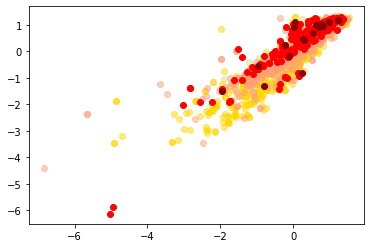

In [6]:
# 可视化
import matplotlib.pyplot as plt
if len(red_data_pca_norm[0])==2:
    color = ['yellowgreen', 'y', 'gold', 'lightsalmon', 'red', 'darkred']
    alpha = [0.25, 0.25, 0.5, 0.5, 1, 1]
    for i, c, a in zip(classname, color, alpha):
        plt.scatter(red_data_pca_norm[np.where(red_label==i), 0], red_data_pca_norm[np.where(red_label==i), 1], c=c, alpha=a)
    plt.show()

In [7]:
# softmax判断函数
def softmax(w, b, x):
    s = np.exp(np.dot(w, x.reshape(x.shape[0],1)) + b)
    return s/s.sum()

In [8]:
# 梯度计算函数
def gradient(w, b, x, multi_label):
    gradient_w = np.zeros([6, len(x[0])])
    gradient_b = np.zeros([6, 1])
    for i in range(len(x)):
        J = softmax(w, b, x[i])
        for j in range(6):
            gradient_w[j] += x[i] * (multi_label[i,j] - J[j])
            gradient_b[j] += multi_label[i,j] - J[j] 
    return gradient_w/len(x), gradient_b/len(x)

In [9]:
import time
# logistics回归函数
def logistics_classification(w, b, ita, delta, maxiter, data, label):
    iteration = 0
    w_ = w
    b_ = b
    time_start = time.time()
    while(True):
        gradient_w, gradient_b = gradient(w_, b_, data, label)
        w_ += ita * gradient_w
        b_ += ita * gradient_b
        if iteration%50 == 0:
            print("iteration: %d ,w = " %iteration)
            print(w_)
        iteration += 1
        if np.linalg.norm(gradient_w) + np.linalg.norm(gradient_b)< delta or iteration >= maxiter:
            break
    time_end = time.time()
    print('%s  %f s' % ("训练耗时为", (time_end - time_start)))
    return w_, b_

In [10]:
# 对原数据进行logistics回归分类
w0 = np.ones([6, len(red_data[0])])
b0 = np.ones([6, 1])
ita = 1e-2
delta = 1e-3
maxiter = 100
w0, b0 = logistics_classification(w0, b0, ita, delta, maxiter, red_data, multi_red_label)
print(w0)
print(b0)

iteration: 0 ,w = 
[[0.98665676 0.99917561 0.99955907 0.99593345 0.99986188 0.97422973
  0.9241109  0.99840114 0.99469399 0.99893873 0.98325094]
 [0.98871242 0.99935032 0.9996061  0.99666172 0.99988428 0.97760684
  0.93456744 0.99866907 0.9956023  0.99910077 0.9860308 ]
 [1.02091755 1.00157787 1.00058621 1.00653883 1.00024918 1.0458745
  1.16324161 1.00258533 1.00855696 1.00154774 1.02479034]
 [1.01943913 1.00110526 1.00064093 1.00565265 1.0001932  1.03623098
  1.08562435 1.00231524 1.00772056 1.00159764 1.02504008]
 [0.99717584 0.99962299 1.00001529 0.99915452 0.99994954 0.99102147
  0.96613717 0.99957844 0.99857691 0.9998256  0.99689801]
 [0.98709829 0.99916795 0.9995924  0.99605884 0.99986193 0.97503648
  0.92631853 0.99845079 0.99484927 0.99898951 0.98398984]]
iteration: 50 ,w = 
[[0.99249185 1.00069429 0.99942477 0.9983709  1.00004273 0.99394688
  0.9652036  0.99913588 0.99740934 0.99922186 0.98873134]
 [0.9904626  1.00284906 0.99833472 1.00277116 1.00005253 0.97006687
  0.9335682

In [11]:
# 对降维且归一化后的数据进行logistic回归分类
w = np.ones([6, len(red_data_pca_norm[0])])
# w2[:, 0] = 1
# w2[:, 1] = -1
b = np.zeros([6, 1])
ita = 1.5
delta = 1e-3
maxiter = 2000
w, b = logistics_classification(w, b, ita, delta, maxiter, red_data_pca_norm, multi_red_label)
print(w)
print(b)

iteration: 0 ,w = 
[[1.00515331 1.00605492]
 [1.01752595 1.01738819]
 [0.9121633  0.83315051]
 [1.04264392 1.07811239]
 [1.0194364  1.05894888]
 [1.00307711 1.00634512]]
iteration: 50 ,w = 
[[ 1.0400571   1.05223914]
 [ 1.17490527  1.11407552]
 [ 1.6039213  -0.02233052]
 [ 0.80949593  1.09502065]
 [ 0.42119914  1.68970151]
 [ 0.95042126  1.0712937 ]]
iteration: 100 ,w = 
[[ 1.09105222  1.12029486]
 [ 1.19570222  1.0569745 ]
 [ 1.73728769 -0.2067543 ]
 [ 0.84749519  0.99977076]
 [ 0.21893194  1.88550503]
 [ 0.90953075  1.14420915]]
iteration: 150 ,w = 
[[ 1.13011545  1.17930241]
 [ 1.21237235  0.99411952]
 [ 1.7805407  -0.27677653]
 [ 0.86599835  0.95238538]
 [ 0.15066804  1.94693614]
 [ 0.86030512  1.20403307]]
iteration: 200 ,w = 
[[ 1.1578434   1.22810271]
 [ 1.23568906  0.94212356]
 [ 1.79734171 -0.3113392 ]
 [ 0.87421462  0.92564932]
 [ 0.12677758  1.96061242]
 [ 0.80813363  1.25485118]]
iteration: 250 ,w = 
[[ 1.17673956  1.26847534]
 [ 1.26128969  0.89848567]
 [ 1.80567771 -0.332

In [12]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [13]:
# # 展示分类器
# x = np.array([-6,1])
# print(w2)
# print(b2)
# for i in range(len(b2)):
#     plt.plot(x,  -x * w2[i,1]/w2[i,0]-b2[i])
    
# for i, c, a in zip(classname, color, alpha):
#     plt.scatter(red_data_pca_norm[np.where(red_label==i), 0], red_data_pca_norm[np.where(red_label==i), 1], c=c, alpha=a)
    
# plt.show()

In [14]:
# 单分类器测试
k = 3 # k = 评分
k -= 3

predicts = sigmoid(np.dot(red_data_pca_norm, w[k]) + b[k])
theta = 0.5
predict = [1 if i > theta else 0 for i in predicts]
print(np.sum(predict == multi_red_label[:, k])/len(predict))
print(np.sum(predict==multi_red_label[:,k]))

0.8486554096310194
1357


In [15]:
# 观察分类器在测试集上的表现

In [16]:
# 降维前
predict0 = np.zeros(len(red_label))
for i in range(len(red_label)):
    predict0[i] = np.argmax(softmax(w0, b0, red_data[i])) + 3
acc0 = np.sum(predict0==red_label)/len(red_label)
print("降维前总精度 = %f" %acc0)

降维前总精度 = 0.424640


In [17]:
# 降维且归一化后
predict = np.zeros(len(red_label))
for i in range(len(red_label)):
    predict[i] = np.argmax(softmax(w, b, red_data_pca_norm[i])) + 3
acc = np.sum(predict==red_label)/len(red_label)
print("降维且归一化后总精度 = %f" %acc)

降维且归一化后总精度 = 0.490932


In [18]:
# 逐类分类
count = np.zeros(6)
acc = np.zeros(6)
for i in range(len(predict)):
    if red_label[i] == 3.0:
        count[0] += 1
        if predict[i] == red_label[i]:
            acc[0] += 1
    if red_label[i] == 4.0:
        count[1] += 1
        if predict[i] == red_label[i]:
            acc[1] += 1
    if red_label[i] == 5.0:
        count[2] += 1
        if predict[i] == red_label[i]:
            acc[2] += 1
    if red_label[i] == 6.0:
        count[3] += 1
        if predict[i] == red_label[i]:
            acc[3] += 1
    if red_label[i] == 7.0:
        count[4] += 1
        if predict[i] == red_label[i]:
            acc[4] += 1
    if red_label[i] == 8.0:
        count[5] += 1
        if predict[i] == red_label[i]:
            acc[5] += 1
print(count)
print(acc)
print(acc/count)

[ 10.  53. 681. 638. 199.  18.]
[  0.   0. 385. 400.   0.   0.]
[0.         0.         0.56534508 0.62695925 0.         0.        ]


In [19]:
# 逐分类器分类
for k in range(6):
    predicts = sigmoid(np.dot(red_data_pca_norm, w[k]) + b[k])
    theta = 0.5
    predict = [1 if i > theta else 0 for i in predicts]
    print(np.sum(predict == multi_red_label[:, k])/len(predict))


0.8486554096310194
0.5115697310819262
0.4140087554721701
0.46153846153846156
0.4052532833020638
0.7754846779237023


In [20]:
predicts = sigmoid(np.dot(red_data_pca_norm, w[2]) + b[2])
theta = 0.5
predict = [1 if i > theta else 0 for i in predicts]
print(predict[:10])
print(multi_red_label[:, 2][:10])
print(np.sum(predict == multi_red_label[:, 2]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1. 1. 1. 0. 1. 1. 1. 0. 0. 1.]
662
